# Machine Learning in Python - Project 1

Due Friday, April 9th by 5 pm UK local time.

Abu Mazhar, Adrian Lee, Elliot Kovanda, Gianluca Bianchi.

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

In the following report we will devlop a model, based upon the hotel bookins data set, which aims to predict whether a booking is likely to be cancelled or not. We aim for our model to be used by the hotel so that they can give booked rooms out to other customers, provided the booking has a high likelihood of being cancelled. Our hope is that the results we produce will help the hotels better understand what causes customers to cancel so that they might improve these aspects of their hotel where possible. 

Before the model was devloped and tested we cleaned the data removing irregularities and what we deem to be incorrect entries. We then studied the data to gain insights about the most significant features affecting the cancellation decsion of a given booking, following this we removed the 

With the now good quality dataset we fitted several models, namely logistic regression, decision trees and random forests. Ultimatley we decided that #### was the superior model with a precidictive accuracy of ####.



## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
d.columns

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

### Guest Data Irregularities


An initial check on our data to decide if a given booking was valid or not was to check that there were the correct number of guests on a booking. This first involved removing bookings with no guests at all. We then proceeded to remove all bookings which contain no adults as we thought this unreasonable for children to be making bookings without adults.

In [7]:
# Total guests 
d["n_guests"] = d.adults + d.children + d.babies

# Drop if no guests
d.drop(d[(d.n_guests < 1) | (np.isnan(d.n_guests))].index, inplace = True)

# # Drop if baby but no adult
# d2.drop(d2[(d2.adults < 1) & (d2.babies >= 1)].index, inplace = True)

# # Bookings with only children
# d2[(d2.adults < 1) & (d2.children >= 1)]

#drop entries with no adults
d = d[~(d.adults==0)]

Finally we decided to join the children and baby variable into a 'family' variable.

In [8]:
d['family'] = ((d['children'] > 0) | (d['babies'] > 0))

For the `adr` column, we removed rows with an Average Daily Rate of 0 as this would also be infeasible.

In [9]:
# drop entries with `adr` == 0
d = d[~(d.adr==0)]

Following the elimination of the invalid rows, we could make more eliminations by considering the parking space requirement for each booking. We said that it was reasonable for each adult on a booking to have their own car parking space, or not have one at all. However, if there was more than one parking space per adult this would be infeasible. We subsequently removed those columns.

In [10]:
# drop entries with more than one car parking space requested per adult (7 in total)
d = d[~(d.required_car_parking_spaces/d.adults > 1)]

#### Total stay and weekday_stay per weekend_stay
Delete obervations when total stay = 0

Long stays appear to check out. At least they are staying continouously for weekdays and weekends.

In [11]:
d["total_stay"] = d.stays_in_weekend_nights + d.stays_in_week_nights

d.drop(d[(d.total_stay < 1)].index, inplace = True)

# Weekday_diff indicates whether stay was continuous (weekdays per weekends should be constant and not above 5)
d["weekday_diff"] = (d.stays_in_weekend_nights - d.stays_in_week_nights) / (1+(0.5*d.stays_in_weekend_nights)) 
#d2[((d2.total_stay > 20) & (d2.weekday_diff < -3))]

In [12]:
# Creates a binary column whether booking is from Portugal or not 
d['is_portugal'] = np.where(d.country == 'PRT', 1, 0)

print(d.groupby(["is_portugal", "hotel"]).is_canceled.mean())
print(d.is_canceled.mean())

is_portugal  hotel       
0            City Hotel      0.269590
             Resort Hotel    0.165445
1            City Hotel      0.667246
             Resort Hotel    0.431115
Name: is_canceled, dtype: float64
0.3748762502987062


In [13]:
d.drop(["country", "is_portugal"], axis = "columns", inplace = True)

#### Cancellation ratio
Gives insight into fraction of bookings cancelled. 

Problem: 2 cancellations / 2 bookings = 1 cancellation / 1 booking = 1

In [14]:
#d2["cancelation_ratio"] = d2.previous_cancellations / (d2.previous_cancellations + d2.previous_bookings_not_canceled)
#d2.cancelation_ratio

#d2["cancelation_ratio"] = d2.previous_cancellations / (d2.previous_cancellations + d2.previous_bookings_not_canceled)
#d2["cancelation_ratio"] = np.where(d2.is_repeated_guest == 0, 0,
                                   #d2.previous_cancellations / (d2.previous_cancellations + d2.previous_bookings_not_canceled))

#d2.cancelation_ratio.unique

#### Customer's lead time
Time between confirmation of booking and arrival. 

Problem: There's little variance in waiting time and waiting time is small relative to lead time. Therefore, near perfect correlation between lead_time and customers_lead.


In [15]:
#import scipy

#d2["customers_lead"] = d2.lead_time - d2.days_in_waiting_list

#d2.customers_lead.mean()
#d2.days_in_waiting_list.mean()

#scipy.stats.pearsonr(d2.customers_lead, d2.lead_time)

#### PPP: Price per paying person per night

In [16]:
# Assume no children if `children` is nan
d['children'] = d['children'].fillna(0)
# Assume no babies if `babies` is nan
d['babies'] = d['babies'].fillna(0)

# Price per paying person per night
d["ppp"] = d.adr / (d.adults + d.children)

#d2.ppp.nlargest(5)
#d2.adr.nlargest(5)

# We drop the excessive ppp > 2000
d.drop(d[(d.ppp > 2000)].index, inplace = True)


#d2[(d2.ppp > 250)]

### Room Type, Allocation and Price

First we studied the avergae price per person 
per night for each of the different room types. The table below shows reasonable results for all rooms types except room type L. We thus choose to drop all features with room type L.

In [17]:
d.groupby("assigned_room_type").ppp.mean().sort_values()

assigned_room_type
L     4.000000
I    46.113427
C    47.785518
H    52.349578
B    55.424493
A    55.469546
D    55.722988
G    59.340325
F    60.263067
E    61.579533
K    65.199925
Name: ppp, dtype: float64

In [18]:
d.drop(d[(d.assigned_room_type == "L")].index, inplace = True)
d.drop(d[(d.reserved_room_type == "L")].index, inplace = True)

We thought it more reasonable to consider a variable combining `assigned_room_type` and `reserved_room_type`. This is acting under the assumption that if a customer does not get what they asked for they will be unhappier and thus more likely to cancel.

In [19]:
# Compare whether assigned and reserved rooms are the same
d['assigned_vs_reserved'] = (d['assigned_room_type'] == d['reserved_room_type'])

We can observe from the histogram below (on a subset of the data) that there are a number of unusually low rates which form a second hump. We should exclude these.###not sure if we should

In [20]:
#sns.displot(
    #data = d2[(d2.ppp < 500)],
    #x = "ppp",
    #kind = "hist",
    #bins = 50
           #)

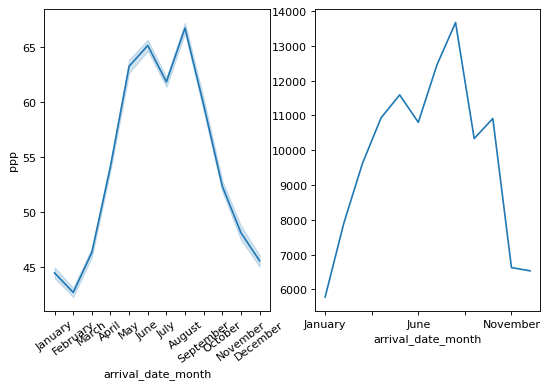

In [21]:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
d['arrival_date_month'] = pd.Categorical(d['arrival_date_month'], categories = ordered_months)
plt.subplot(1, 2, 1)
sns.lineplot(x='arrival_date_month', y = 'ppp', data = d)
plt.xticks(rotation=37)

plt.subplot(1, 2, 2)
d.groupby('arrival_date_month')['arrival_date_month'].count().plot(kind='line')

plt.show()

In [22]:
# Fill nan's in the `agent` column with 536 (original range of codes for `agent` is 1 to 535)
d['agent'] = d['agent'].fillna(536)
# Fill nan's in the `company` column with 536 (original range of codes for `agent` is 6 to 543)
d['company'] = d['company'].fillna(544)

# Assume country is PRT if `country` is nan
#d['country'] = d['country'].fillna('PRT')

In [23]:
# Compare whether assigned and reserved rooms are the same
d['assigned_vs_reserved'] = (d['assigned_room_type'] == d['reserved_room_type'])

#### Relative PPP
How expensive was the ppp relative to similar bookings?

In [24]:
d.columns

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'company', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'n_guests', 'family', 'total_stay',
       'weekday_diff', 'ppp', 'assigned_vs_reserved'],
      dtype='object')

##### First we find elements that influence ppp
This allows us to later control for these elements.

- Hotel
- Month
- Lead time
- Suprisingly not room-type

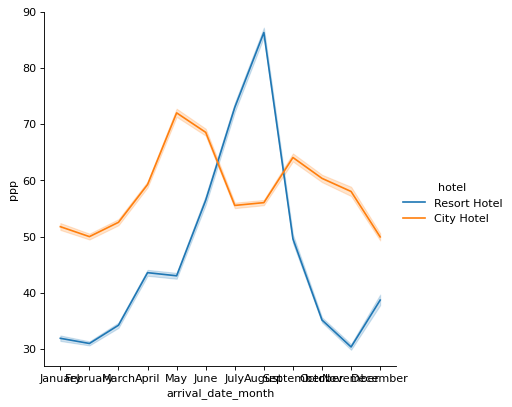

In [25]:
sns.relplot(
    data = d,
    x = "arrival_date_month",
    y = "ppp",
    hue = "hotel",
    kind = "line"
           )

We find some evidence that shorter-lead bookings tend to be more expensive. However, this should be fairly coarse: For instance, short-term (<50), medium (50-200) and long-term (200+).

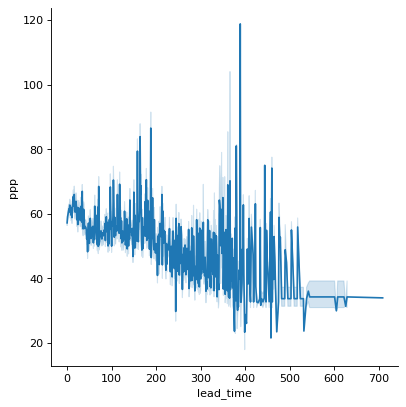

In [26]:
sns.relplot(
    data = d,
    x = "lead_time",
    y = "ppp",
    kind = "line"
           )

Interestingly, we observe that shorter-term bookings are made predominantly in the cheaper off-season. The spikes in the previous chart are likely caused by few short-term peak-season bookings which will be most expensive. This strengthens support to control for lead-time. 

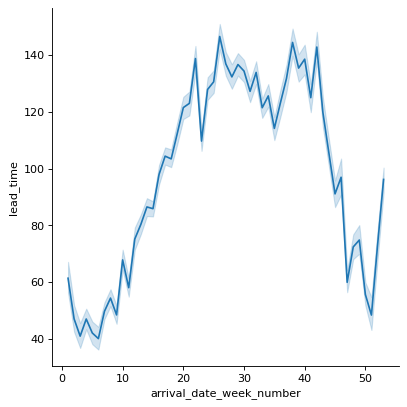

In [27]:
sns.relplot(
    data = d,
    x = "arrival_date_week_number",
    y = "lead_time",
    #hue = "hotel",
    kind = "line"
           )

In [28]:
# Creating a new variable that categorises lead time.
# This can later be used to group-by.
d["lead_cat"] = np.where(d.lead_time < 50, "short", np.where(d.lead_time < 200, "medium", "long"))

d.lead_cat

2          short
3          short
4          short
5          short
6          short
           ...  
119385     short
119386    medium
119387     short
119388    medium
119389      long
Name: lead_cat, Length: 117165, dtype: object

Surprisingly there is no strong evidence for a difference in the price of rooms. We shall therefore not control for room types when assessing the relative price of a booking.

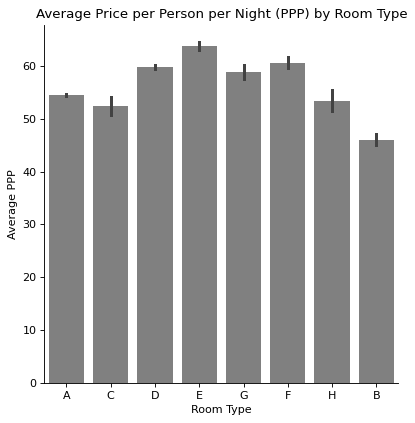

In [29]:
sns.catplot(
    data = d,
    x = "reserved_room_type",
    y = "ppp",
    #hue = "hotel",
    kind = "bar",
    color = "grey"
           ).set(title='Average Price per Person per Night (PPP) by Room Type', 
      xlabel='Room Type', 
      ylabel='Average PPP')

We will now compute the mean ppp for each type of booking

In [30]:
# Get the means for each type of booking
ppp_ref = d.groupby(["hotel", "arrival_date_month", "lead_cat"]).ppp.mean()
ppp_ref.columns = ['hotel', 'arrival_date_month', 'lead_cat']

ppp_ref = ppp_ref.reset_index()

ppp_actual = d[["hotel", "arrival_date_month", "lead_cat", "ppp"]]

In [31]:
# Create an ID column for the merge
ppp_ref["ppp_ID"] = ppp_ref["hotel"].astype(str) + ppp_ref["arrival_date_month"].astype(str) + ppp_ref["lead_cat"].astype(str)
ppp_actual["ppp_ID"] = ppp_actual["hotel"].astype(str) + ppp_actual["arrival_date_month"].astype(str) + ppp_actual["lead_cat"].astype(str)

C:\Users\Ellio\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
# Drop unnecessary columns from reference frame
ppp_ref.drop(["hotel", "arrival_date_month", "lead_cat"], axis = "columns", inplace = True)

In [33]:
# Merge the two data frames 
ppp_joined = pd.merge(ppp_actual, 
                     ppp_ref, 
                     on ='ppp_ID', 
                     how ='left')

In [35]:
# Computes the actual price relative to the expected (mean) price for a booking of that category
ppp_joined["relative_ppp"] = ppp_joined.ppp_y / ppp_joined.ppp_x 

In [37]:
d.reset_index(inplace = True)

In [38]:
# We add the new column to the existing data frame
d["relative_ppp"] = ppp_joined.relative_ppp

#### Why do we have nan in the relative_ppp feature?
Had to reset index on the original data frame. Now no longer nan values.

#### Binary is_company feature
There are too many individual companies to analyse however there may still be meaningful information in whether or not a booking was a corporate booking.

In [41]:
d["is_company"] = np.where(d.company == 544, 0, 1)

In [42]:
d.columns

Index(['index', 'is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'company', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'n_guests', 'family', 'total_stay',
       'weekday_diff', 'ppp', 'assigned_vs_reserved', 'lead_cat',
       'relative_ppp', 'is_company'],
      dtype='object')

In [53]:
d2 = d.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month','children','babies','reserved_room_type','assigned_room_type','agent','company',
        'required_car_parking_spaces','n_guests','weekday_diff', 'lead_cat', 'index'], axis=1)

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

In [54]:
list(d2.columns)

['is_canceled',
 'hotel',
 'lead_time',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'total_of_special_requests',
 'family',
 'total_stay',
 'ppp',
 'assigned_vs_reserved',
 'relative_ppp',
 'is_company']

In [55]:
perc_missing_data = pd.DataFrame([d2.isnull().sum(),d2.isnull().sum()*100.0/d2.shape[0]]).T
perc_missing_data.columns = ['No. of Missing Data', '% Missing Data']
perc_missing_data

,No. of Missing Data,% Missing Data
is_canceled,0.0,0.0
hotel,0.0,0.0
lead_time,0.0,0.0
arrival_date_week_number,0.0,0.0
stays_in_weekend_nights,0.0,0.0
stays_in_week_nights,0.0,0.0
adults,0.0,0.0
meal,0.0,0.0
market_segment,0.0,0.0
distribution_channel,0.0,0.0


In [56]:
y = d2.is_canceled
X = pd.get_dummies(d2.drop(["is_canceled","deposit_type"], axis=1), drop_first=True)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=1)

In [62]:
pipeline = Pipeline([('DecisionTreeClassifier', DecisionTreeClassifier())])

params = {'DecisionTreeClassifier__max_depth': np.arange(2,10), 'DecisionTreeClassifier__min_samples_leaf': [1000]}

KF = KFold(n_splits = 5, shuffle = True, random_state = 1)

model = GridSearchCV(pipeline, params, cv = KF, scoring = 'roc_auc').fit(X_train, y_train)

In [63]:
print(model.best_estimator_)
print(model.best_score_)

Pipeline(steps=[('DecisionTreeClassifier',
                 DecisionTreeClassifier(max_depth=9, min_samples_leaf=1000))])
0.8482209896185389


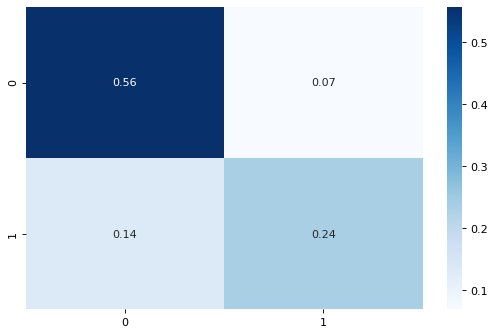

In [64]:
sns.heatmap(confusion_matrix(y_train, model.predict(X_train))/len(y_train), annot = True, cmap="Blues");

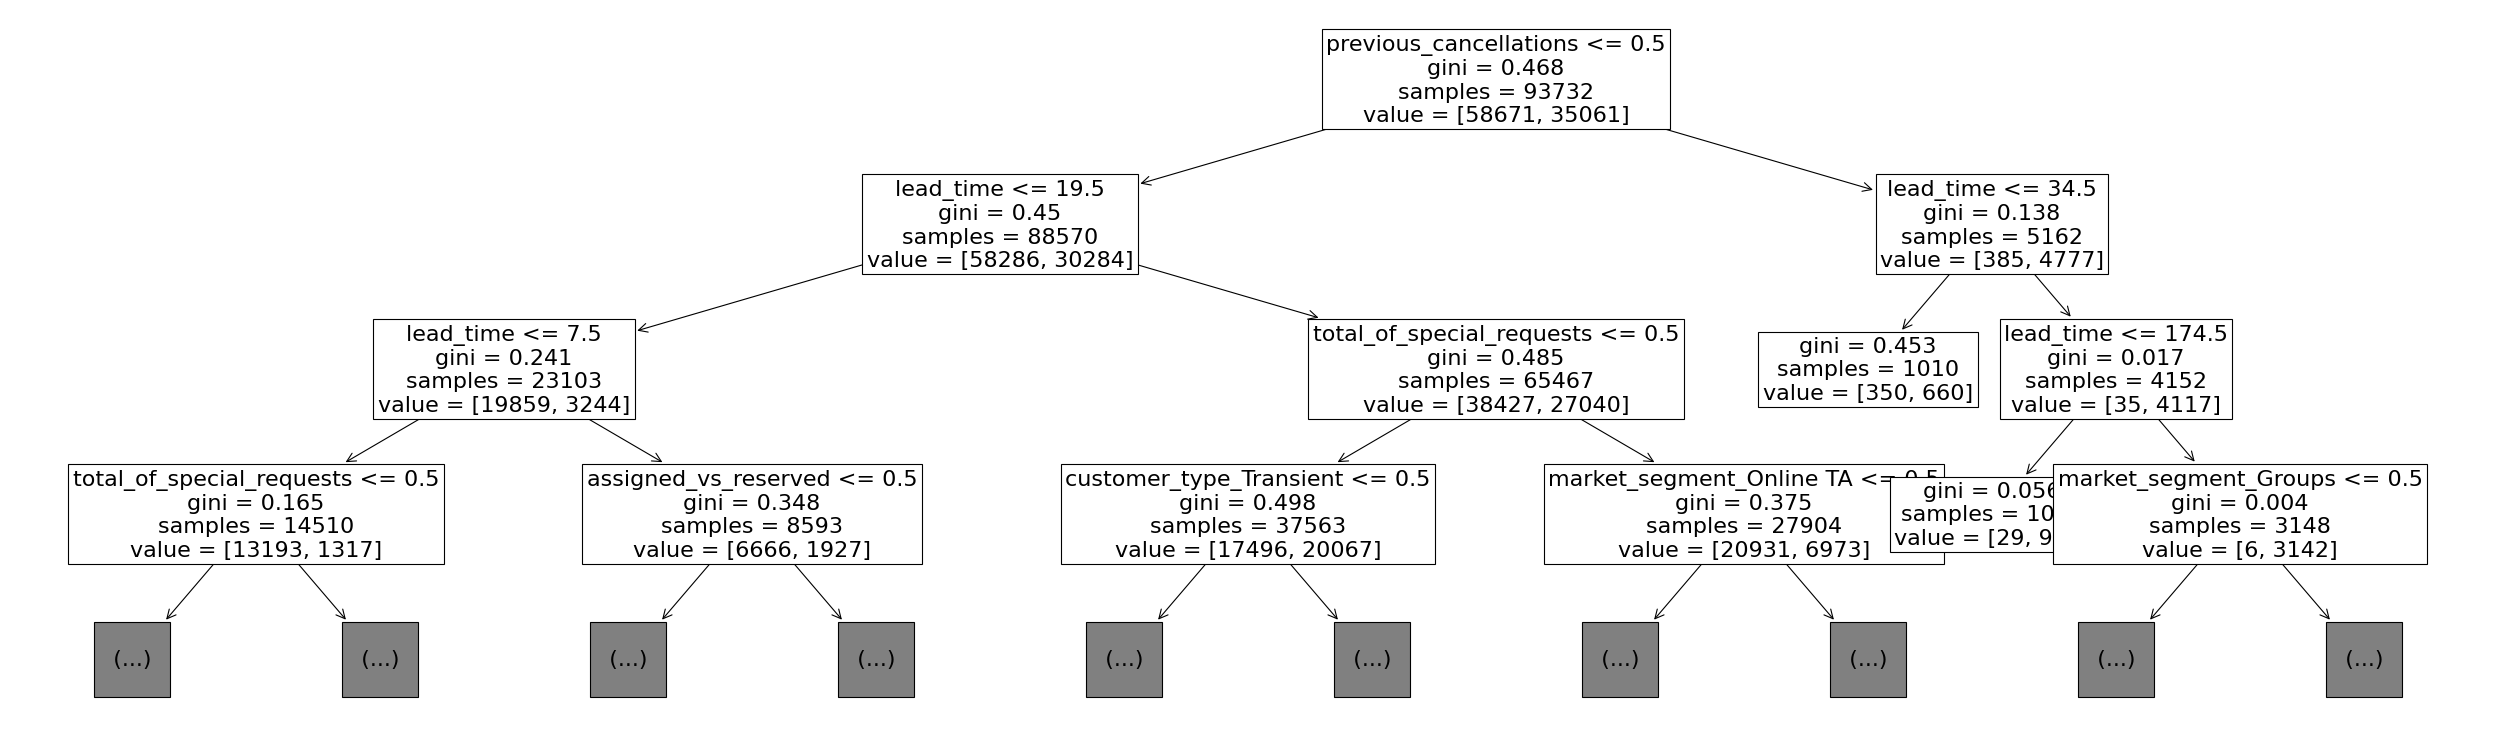

In [65]:
plt.figure(figsize=(40,12))
plot_tree(model.best_estimator_.named_steps['DecisionTreeClassifier'], 
          feature_names = X.columns, fontsize=20, max_depth=3)
plt.show();

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

## 5. Convert Document

In [52]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb

[NbConvertApp] Converting notebook proj2.ipynb to pdf
[NbConvertApp] Support files will be in proj2_files\
[NbConvertApp] Making directory .\proj2_files
[NbConvertApp] Writing 195075 bytes to .\notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "C:\Users\Ellio\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\Ellio\anaconda3\lib\site-packages\jupyter_core\application.py", line 268, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\Ellio\anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Ellio\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 340, in start
    self.convert_notebooks()
  File "C:\Users\Ellio\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 510, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "C:\Users\